# Distributed XGBoost with Dask on CML

In this notebook we'll demonstrate a simple application for detecting credit card fraud by training a distributed XGBoost model using Dask, a library for scaling and parallelizing Python applications. [Dask](https://www.dask.org/) allows easy management of distributed workers and excels at handling large distributed data science workflows. The [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) package now includes [Dask integration](https://xgboost.readthedocs.io/en/latest/tutorials/dask.html) through two APIs: a functional interface (that we'll demonstrate here) and one that is modeled after Scikit-Learn. 


### Distributed computing
It's important to understand what we mean by "distributed" computing, since there are several paradigms for scaling machine learning workflows. 

**Memory-constrained.**
In this scenario the data is larger than can comfortably fit into memory and must instead be distributed across the nodes of your cluster. This necessitates distributing your ML model across those same nodes, a feature of ensemble models like XGBoost. This is the type of distributed computing we demonstrate in this notebook. 

**Compute-constrained.** 
In this scenario, the data fits in memory but the model size or training complexity is such that execution would simply take too long to complete in a reasonable time. This can happen, for example, when tuning a large model's hyperparameters or when performing cross validation. One way to handle this is to parallelize the computation, e.g., use each node in the cluster to train a separate set of hyperparameters for a given model. 


We do *not* perform this kind of distributed computing because, in our scenario, all the nodes in the cluster are already being used to handle the distributed data load! Instead, we perforrm hyperparameter tuning _sequentially_. We demonstrate how we roll our own quick and dirty hyperparameter tuning loop to handle this. 
 

### A note on the dataset
We'll work with a sample of the [credit card fraud dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) curated by the machine learning group at Université Libre de Bruxelles. (You can obtain the full dataset by creating a Kaggle account and downloading from the link above.) The same group have a [handbook](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html) detailing the application of machine learning for fraud detection, which provides considerably more depth than we do here. Creating a realistic fraud detection system is far too mighty a task for a single humble notebook, and so the dataset here serves only as an example for the purpose of demonstrating the technologies. Namely: scaling the training of XGBoost on a Dask cluster on CML. Throughout the process we'll also demonstrate how to use other supporting Dask libraries for a nearly end-to-end scaled ML workflow.


## Overview
In addition to demonstrating Dask + XGBoost, this notebook also highlights a typical data science workflow. For that, we perform the following: 
* We first [load, explore, and visualize](#load_data) the credit card fraud dataset
* Next, we establish [baseline classifiers](#baselines) as a gut check, and to serve as a point of comparison for more complex models
* We spin up a Dask cluster and train a [distributed XGBoost](#distributed_xgboost) classifier
* We perform [tuning](#hp_tuning) of the XGBoost hyperparamters
* Finally, we compare our best XGBoost model to our baselines and [validate](#validation) on a hold-out set. 

The code in this notebook was inspired by the [documentation](https://xgboost.readthedocs.io/en/stable/tutorials/dask.html) and [this blog post](https://medium.com/rapids-ai/a-new-official-dask-api-for-xgboost-e8b10f3d1eb7) published by RAPIDS AI, both excellent sources for further details. 

In [2]:
import cdsw
import pprint
from tqdm import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import xgboost as xgb

from scipy.stats import uniform, loguniform, randint
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, precision_recall_curve
from sklearn.model_selection import ParameterSampler # Use ParameterGrid for grid search
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from dask import dataframe as dd
from dask.distributed import Client
import dask_ml

from utils.dask_utils import run_dask_cluster

In [3]:
import warnings
warnings.filterwarnings("ignore")

<a id='load_data'></a>
## Load Data

The data comes somewhat pre-engineered reduced, having gone through (at least) PCA. This was done in the name of privacy preservation, but also means the data is in reasonable shape to put directly into a supervised learning pipeline.

We begin by loading the data into a Dask DataFrame, which has much of the same functionality of a traditional Pandas Dataframe. Recall from the Dask Intro notebook that Dask performs _lazy_ execution so this DataFrame is not yet populated with values until explicit execution, e.g., calling `.head()` on the DataFrame.

In [5]:
dask_df = dd.read_csv("../data/creditcardsample.csv", assume_missing=True)

In [6]:
dask_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
dask_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1.0
1,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0.0
2,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0.0
3,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0.0
4,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0.0


## Feature engineering

The task we perform here is a "point-like" prediction of fraud, in the sense that transactions are not linked by any id, so we can't do any analysis of events from the same card over time. As such, each incoming datapoint will be subject to a prediction independent of the others. Time could be used as a feature, but only in the naive sense (time of day, etc). Neglecting time seems appropriate for this point-like prediction task.

In [8]:
dask_df = dask_df.drop(columns=['Time'])

The target class is heavily imbalanced -- this is expected since (hopefully) fraudulent transactions are a rare occurance!

In [9]:
class_counts = dask_df.Class.value_counts().compute()

print(f"""There are {class_counts[1]} identified cases of fraud in {class_counts.sum()} total cases. 
        That's only {100 * class_counts[1]/class_counts.sum():.2f}%!""")

There are 149 identified cases of fraud in 94926 total cases. 
        That's only 0.16%!


Maybe some features will be well correlated with the target. Let's do a visual spot check. Because there's such a huge class imbalance, we randomly downsample the dominant class to match the prevalence of the minority class.

In [13]:
sample_df = dd.concat([dask_df[dask_df.Class == 1], dask_df[dask_df.Class == 0].sample(frac=0.0017)]).compute().reset_index()

Now that we've created a small sample, we can convert this to a standard pandas dataframe for use in our plotting function. 

In [11]:
melted_cc = (
    sample_df
    .drop("Amount", axis="columns")
    .melt(id_vars=["Class"],
          value_vars=[c for c in dask_df.columns if c not in ["Class", "Amount"]])
)

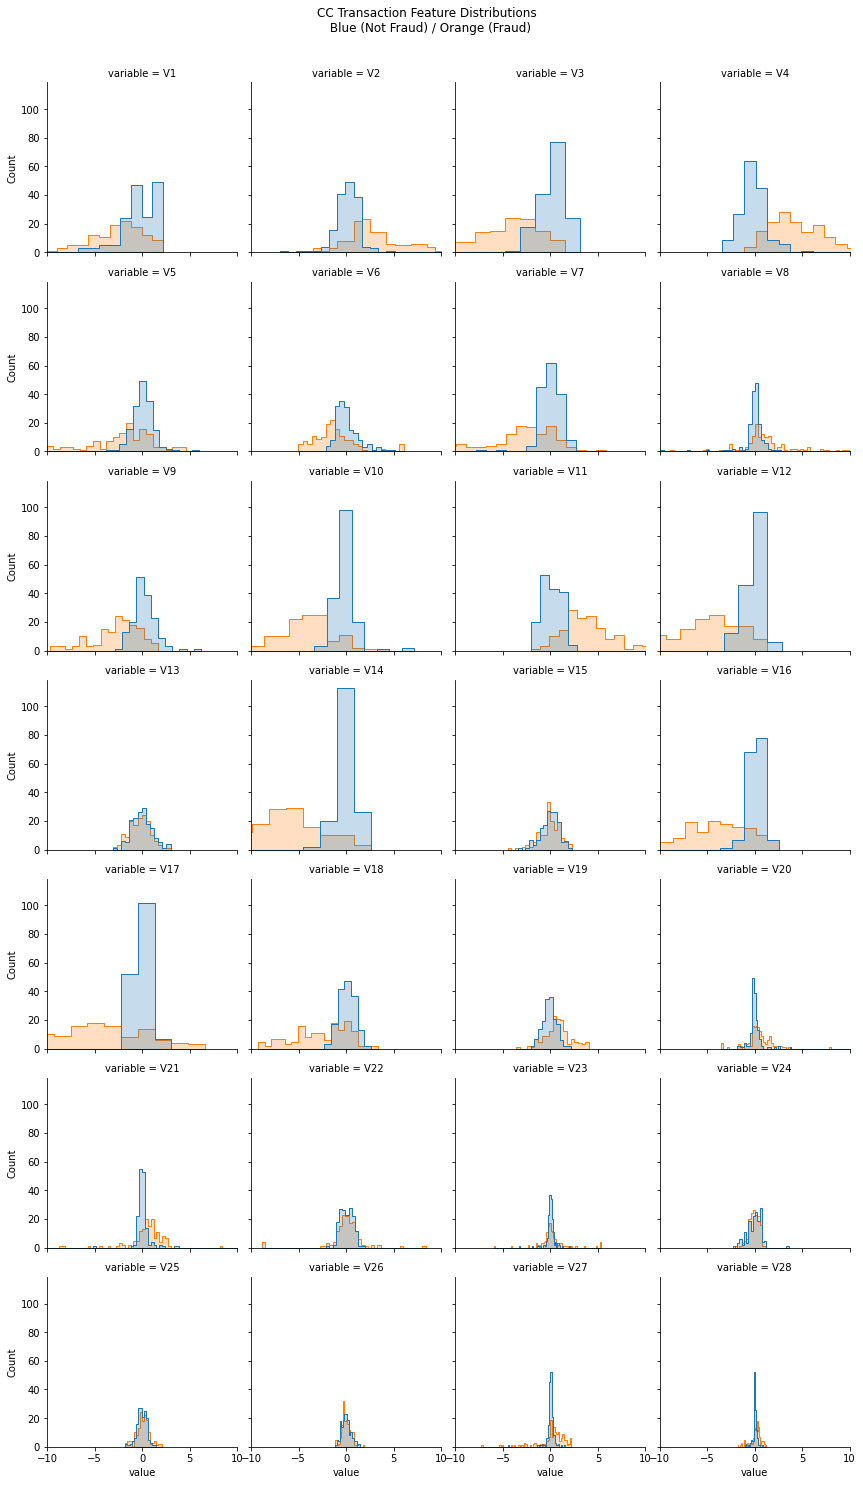

In [28]:
grid = sns.FacetGrid(melted_cc, col="variable", col_wrap=4)
grid.map_dataframe(sns.histplot, x="value", hue="Class", element="step")
grid.set(xlim=(-10,10));
grid.fig.subplots_adjust(top=0.93)
grid.fig.suptitle(f"CC Transaction Feature Distributions \n Blue (Not Fraud) / Orange (Fraud)");

It looks like there's some reasonable separation between fraudulent and non-fradulent transactions via some of the PCA feature distributions. This signals that there's a good chance we can learn to discriminate fraudulent transactions on the basis of these features. (Even those distributions that overlap extremely well may be useful in combination with other features). Keep in mind that that downsampling non-fraudulent transactions so severely introduces a lot of statistical noise - run the sampling repeatedly to draw new samples.

The scale of the `Amount` variable differs from the PCA variables above, so we plot it separately.

<AxesSubplot:xlabel='Amount', ylabel='Count'>

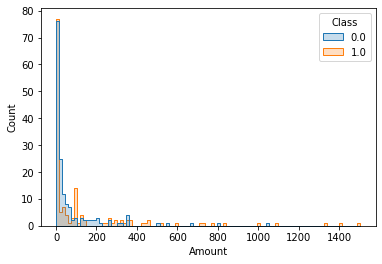

In [11]:
sns.histplot(
    sample_df,
    x="Amount", hue="Class", element="step", bins=100
)

We see that the features are not perfect standard normal distributions, but are all close to mean zero and standard deviation one, excepting the transaction amount. Taking all features `V1` through `V28` and `Amount` as our feature matrix, we can apply standard scaling to all (it will not harm those already scaled, and performance is not a concern).

## Train/dev/validation split

Before we compute anything, even baselines, let's establish a train test split. We'll do 70% train, 20% dev, and 10% validation. 

In [12]:
# Class is our target variable so we separate this column from the dask dataframe
y = dask_df['Class']
X = dask_df[dask_df.columns.difference(['Class'])]

In [13]:
X_train, X_dev, y_train, y_dev = dask_ml.model_selection.train_test_split(X, y, test_size=0.3, shuffle=True)
X_dev, X_val, y_dev, y_val = dask_ml.model_selection.train_test_split(X_dev, y_dev, test_size=0.333, shuffle=True)

Let's verify that our splits contain class imbalances that are approximately equal to our original dataset

In [14]:
print(y_train.sum().compute() / len(X_train.compute()))
print(y_dev.sum().compute() / len(X_dev.compute()))
print(y_val.sum().compute() / len(X_val.compute()))

0.001462098488160017
0.0019501396721657092
0.0015608740894901144


<a id='baselines'></a>

## Baseline Models
We should always start with some baseline classifiers, in order to gut-check whether our resulting (more sophisticated) model is sensible. 

### Dummy Classifier
A sensible baseline for binary classification is to always predict majority class. In our case, that means predicting nothing is fraud, everything is fine. That's gonna give us a heck of a good accuracy.

In [15]:
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('majority_classifier', DummyClassifier(strategy="most_frequent"))
])

baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('majority_classifier',
                 DummyClassifier(strategy='most_frequent'))])

In [16]:
print("Score on the train set:", baseline_pipeline.score(X_train, y_train))
print("Score on the dev set:", baseline_pipeline.score(X_dev, y_dev))

Score on the train set: 0.99853790151184
Score on the dev set: 0.9980498603278343


A better metric would be area under the PR curve. Maximizing this then allows us to choose an informed threshold (trading off precision and recall to suit the eventual application).

In [17]:
def area_under_pr_curve(predictions, labels, return_pr=False):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    area = auc(recall, precision)
    if return_pr:
        return area, precision, recall
    return area

In [18]:
area, baseline_precision, baseline_recall = area_under_pr_curve(baseline_pipeline.predict(X_dev), y_dev, return_pr=True)
area

0.5009750698360829

What does this number mean? Let's recall how sklearn constructs a [PR curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html). The first precision and recall values of the PR curve are precision=class balance and recall=1.0 which corresponds to a classifier that always predicts the "positive class" (fraud, in this case). Because we have such an imbalanced dataset, this point is essentially [0.0017, 1.].  Since our dummy classifier only predicts the **majority class** (_not_ fraud), there are no thresholds over which to build the PR curve, and so, by default, the last precision and recall values in the curve are 1. and 0. This results in a line from essentially [0, 1] to [1, 0], which yields an aucpr of approximately 0.5. This is the lowest aucpr we could possibly get for this problem so we should certainly be able to improve it! 

### Logistic Regression
Let's do the next most simple thing: logistic regression with no regularization.


In [19]:
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty="none"))
])
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression(penalty='none'))])

In [20]:
area, logistic_precision, logistic_recall = area_under_pr_curve(logistic_pipeline.predict(X_dev), y_dev, return_pr=True)
area

0.7560259292128263

There we go -- some reasonable baselines that we can compare our XGBoost model against. It's time to up our ML game and compute! 

<a id='distributed_xgboost'></a>

## Distributed XGBoost with Dask on CML

So far, we've been using Dask DataFrames as a drop-in replacement for Pandas. Either can be used interchangeably in sklearn models, as we demonstrated above. These baseline models were run on the single CPU available to this notebook, but now it's time to see how we can use XGBoost+Dask to perform distributed training over multiple CPUs. 

First we spin up a Dask cluster with CML workers using the `run_dask_cluster` utility, which wraps together the steps we detailed in the Dask Intro notebook, and connect the cluster to a Dask client. 


In [21]:
NUM_WORKERS=2
CPU_PER_WORKER=1
MEM_PER_WORKER=2
DASHBOARD_PORT=8090

In [22]:
dask_cluster = run_dask_cluster(num_workers=NUM_WORKERS, 
                                cpu=CPU_PER_WORKER, 
                                memory=MEM_PER_WORKER, 
                                dashboard_port=DASHBOARD_PORT
                               )

In [23]:
client = Client(dask_cluster['scheduler_address'])

We can view the cluster workload via the Dask dashboad, linked below. 

In [24]:
dask_cluster['dashboard_address']

'https://2jhz8n0k1mcmvqhd.fflab-4.cdsw-int.cloudera.com/status'


XGBoost requires data in a specialized format called a DMatrix, a data object that has been optimized for memory efficiency. Below, we perform an operation that converts our Dask DataFrames to a Dask DMatrix. Under the hood, this process may place one or more DataFrame partitions onto one or more DMatrix objects. For large datasets, this may take some time because we are literally moving the data around the cluster we just spun up (which is why we pass it the Dask `client`).

In [25]:
# X and y must be Dask dataframes or arrays
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
ddev = xgb.dask.DaskDMatrix(client, X_dev, y_dev)

Next we define some general parameters for the XGBoost model, including a logistic objective function (since this is ultimately a classification problem), an evaluation metric (area under the PR curve), and we specify the `tree_method` to `hist` which supports distribution. We also pass a list of evaluation datasets. For each round of boosting, the model will compute the `eval_metric` on each dataset in the `eval_list`. In this case, we include both the train and dev sets. 

In [26]:
eval_list = [(ddev,'dev'), (dtrain,'train')]
num_round = 5

params = {
    "verbosity": 2,
    "tree_method": "hist",
    "objective": "reg:logistic",
    "eval_metric": "aucpr"  
}

output = xgb.dask.train(client, params, dtrain, num_round, evals=eval_list)

In [27]:
output

{'booster': <xgboost.core.Booster at 0x7f59983b7430>,
 'history': {'dev': OrderedDict([('aucpr',
                [0.6473058901233305,
                 0.82269329510901,
                 0.8304071462959678,
                 0.8438957828515792,
                 0.8402274269007418])]),
  'train': OrderedDict([('aucpr',
                [0.806276489473136,
                 0.8464042584540278,
                 0.8488407488091982,
                 0.8529916207550472,
                 0.8535885471355388])])}}

The output of `xgb.dask.train` contains both the trained model (`booster`) as well as the training `history`. Specifically, we see the achieved aucpr metric for each round of boosting for each evaluation dataset. Training with XGBoost's default hyperparameters has yielded a model that already beats out our baseline classifiers! This indicates that our model is learning some meaningful relationships within the transaction data.   

<a id='hp_tuning'></a>

### Hyperparameter tuning
While our default XGBoost model may already be learning strong statistical relationships, this model is so complex that it usually pays to perform hyperparameter tuning to maximize learning. As discussed at the beginning of this notebook, because we've already distributed the data and model across our Dask cluster, we'll perform _sequential_ hyperparameter tuning. That is, we'll harness the entire cluster and train one set of hyperparameters at a time. This is useful when our data is too large to fit on the memory resources of a single node.  

In order to streamline the process we created the function below, which performs a simple random hyperparameter search. Replacing `ParameterSampler` with `ParameterGrid` will yield a grid search instead. 

In [28]:
def tune_xgboost(client, dtrain, params, search_space, num_samples, random_state=42):
    """
    Perform a random hyperparameter search for a distributed XGBoost model. 
    Returns the best model, best score, best parameters, and a Pandas DF containing 
    all hyperparameter tuning details. 
    
    Keyword arguments: 
    client -- Dask client
    dtrain -- training data in DaskDMatrix object
    params -- dict of XGBoost parameters that remain constant throughout hyperparameter tuning
    search_space -- dict of XGBoost parameters that will undergo random sampling
    num_samples -- number of random hyperparameter samples
    random_state -- random state initialization for the random hyperparameter sampling function
    """
    best_params, best_score, best_model = None, 0, None
    hp_results = list()
    
    try:
        num_round = params.pop("num_round")
    except KeyError:
        print("Number of boosting rounds missing! Please supply `num_round` to params")
        return

    try:
        eval_list = params.pop("eval_list")
    except KeyError:
        print("No `eval_list` data provided. Hyperparameter tuning will be scored on the train set only.")
        eval_list = [(dtrain, "train")]

    for hp in tqdm(ParameterSampler(search_space, n_iter=num_samples, random_state=random_state)):
        params.update(hp)
        params_key = str(params)

        # Try to find new best model
        output = xgb.dask.train(client, params, dtrain, num_round, evals=eval_list)
        score = output["history"]["dev"]["aucpr"][-1]
        if score > best_score:
            best_params, best_score = params_key, score
            best_model = output["booster"]

        # Save history (scores) for reference
        hp["score"] = score
        for _, sample in eval_list:
            for metric in params["eval_metric"]:
                hp[f"{sample}_{metric}"] = output["history"][sample][metric]
        hp_results.append(hp)

        tqdm._instances.clear()  # jupyter notebook hack

    history_df = pd.DataFrame(hp_results)
    return {
        "best_model":best_model, 
        "best_params":best_params, 
        "best_score":best_score, 
        "hp_history":history_df
        }

Next, we add another metric for evaluation -- the model's internal `error`. This can be used as a model diagnostic. 

We also add a new dict which holds the hyperparameters we might wish to tune. We include a handful of common ones, however, you can explore the full set of options [here](https://xgboost.readthedocs.io/en/latest/parameter.html). 

In [29]:
eval_list = [(ddev,'dev'), (dtrain,'train')]
eval_metrics = ["error", "aucpr"]

# These parameters will remain constant during the tuning process
params = {
    "verbosity": 2,
    "tree_method": "hist",
    "objective": "reg:logistic",
    "eval_metric": eval_metrics,
    # The following are not hyperparameters of the model but are used during training. 
    "eval_list": eval_list,  
    "num_round": 5
}

# These parameters will be tuned. 
search_space = {
    "learning_rate": uniform(0, 1),      # learning rate
    "gamma": loguniform(1e-6, 1e+1),     # minimum loss to make partition 
    "max_depth": randint(1, 20),         # max tree depth
    "min_child_weight": uniform(0, 10),  # min weight of node for further partitioning
    "max_delta_step": uniform(0, 10),    # max weight of each tree 
    "subsample": uniform(0, 1),          # subsample ratio of training examples
    "lambda": uniform(0, 1),             # L2 reg
    "alpha": uniform(0, 1),              # L1 reg
}

results = tune_xgboost(client, dtrain, params, search_space, num_samples=20)

100%|███████████████████████████████████████████| 20/20 [01:19<00:00,  3.99s/it]


In [30]:
print(f"The best aucpr score on the dev set is found to be {results['best_score']}")

The best aucpr score on the dev set is found to be 0.8392517884715062


In [31]:
print(f"Corresponding to these XGBoost parameters:")
pprint.pprint(eval(results['best_params']))

Corresponding to these XGBoost parameters:
{'alpha': 0.2694123337985215,
 'eval_metric': ['error', 'aucpr'],
 'gamma': 5.115388887937022e-05,
 'lambda': 0.16829104217293056,
 'learning_rate': 0.21876421957307024,
 'max_delta_step': 5.581020020173412,
 'max_depth': 17,
 'min_child_weight': 0.6489224710898156,
 'objective': 'reg:logistic',
 'subsample': 0.2539154139343447,
 'tree_method': 'hist',
 'verbosity': 2}


And we can examine all the hyperaparameter combinations we tried in the accompanying `hp_history`. 

In [32]:
results["hp_history"]

,alpha,gamma,lambda,learning_rate,max_delta_step,max_depth,min_child_weight,subsample,score,dev_error,dev_aucpr,train_error,train_aucpr
0,0.374540,4.518561,0.731994,0.598658,1.560186,19,0.999749,0.459249,0.816082,"[0.0010014230748959, 0.0008960101196437, 0.000...","[0.5887542148036186, 0.7860610473364512, 0.814...","[0.00061800039190269, 0.00057278085103176, 0.0...","[0.6877983546958789, 0.7679374585040443, 0.789..."
1,0.333709,0.000010,0.650888,0.056412,7.219988,6,0.007788,0.992212,0.817047,"[0.0009487165972698, 0.0009487165972698, 0.000...","[0.649167721237965, 0.649167721237965, 0.81158...","[0.00028639042551588, 0.00028639042551588, 0.0...","[0.8129394497953477, 0.8129394497953477, 0.853..."
2,0.617482,0.019124,0.007066,0.023062,5.247747,10,0.466657,0.973756,0.827670,"[0.0008433036420176, 0.0005797712538871, 0.000...","[0.8149831478538107, 0.8222580434059312, 0.825...","[0.00024117088464495, 0.00024117088464495, 0.0...","[0.9050544845896731, 0.9314313941711511, 0.931..."
3,0.232771,0.000004,0.618386,0.382462,9.832309,3,8.599404,0.680308,0.761168,"[0.0010014230748959, 0.0008433036420176, 0.000...","[0.53367623513173, 0.7531571962191901, 0.75855...","[0.00060292721161238, 0.00051248812987052, 0.0...","[0.6669130472012694, 0.7719967276712862, 0.770..."
4,0.450499,0.000001,0.942202,0.563288,3.854165,2,6.842330,0.440152,0.776733,"[0.0006324777315132, 0.0006324777315132, 0.000...","[0.7425723815163563, 0.7658808683269847, 0.786...","[0.00052756131016083, 0.00052756131016083, 0.0...","[0.6850561986970437, 0.7010791283514447, 0.731..."
5,0.122038,0.002926,0.034389,0.909320,2.587800,8,7.553614,0.425156,0.786147,"[0.000527064776261, 0.000527064776261, 0.00057...","[0.7541000222845473, 0.7789573372582194, 0.779...","[0.00060292721161238, 0.0004823417692899, 0.00...","[0.6410609159449393, 0.7131556155260893, 0.732..."
6,0.207942,0.009417,0.031313,0.842285,4.497541,10,8.948274,0.597900,0.769438,"[0.0010014230748959, 0.0008433036420176, 0.000...","[0.6508273373165742, 0.7337938142295953, 0.742...","[0.00060292721161238, 0.00051248812987052, 0.0...","[0.6596795758681385, 0.75925304947586, 0.74988..."
7,0.921874,0.000004,0.195983,0.045227,3.253303,16,7.473201,0.539692,0.761152,"[0.0010014230748959, 0.0008960101196437, 0.000...","[0.5431571456932338, 0.7740522680703453, 0.770...","[0.00060292721161238, 0.00057278085103176, 0.0...","[0.6383097649726662, 0.7370388491461028, 0.734..."
8,0.586751,5.711986,0.607034,0.275999,2.962735,13,0.745506,0.986887,0.821012,"[0.0008433036420176, 0.0008960101196437, 0.000...","[0.6131656259887244, 0.8114019124750836, 0.800...","[0.00051248812987052, 0.00058785403132207, 0.0...","[0.7045844938202201, 0.8116312888400391, 0.812..."
9,0.772245,0.000025,0.005522,0.815461,7.068573,3,7.901755,0.605960,0.774906,"[0.0010014230748959, 0.0008433036420176, 0.000...","[0.6873751567632653, 0.7343994579799011, 0.742...","[0.00060292721161238, 0.00051248812987052, 0.0...","[0.6678834418023936, 0.7475348293207549, 0.741..."


### Compare to baselines

We already know that the aucpr metric achieved by the XGBoost model exceeds that of our baseline classifiers. Let's visualize their PR curves. 

In [33]:
predictions = xgb.dask.predict(client, results['best_model'], ddev)
_, xgboost_precision, xgboost_recall = area_under_pr_curve(predictions, y_dev, return_pr=True)

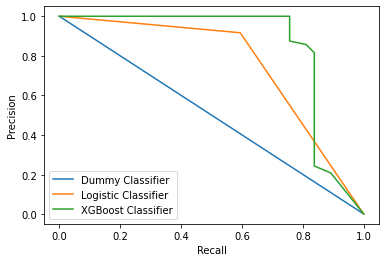

In [34]:
plt.plot(baseline_recall, baseline_precision, label='Dummy Classifier')
plt.plot(logistic_recall, logistic_precision, label='Logistic Classifier')
plt.plot(xgboost_recall, xgboost_precision, label='XGBoost Classifier')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend();

<a id='validation'></a>

## Validation
Now that we have a tuned XGBoost model that's been trained on the train set, evaluated on the dev set and compared to our baselines, it's time to evaluate it on our final holdout - the validation set. This gives us an idea of how our model will perform _in the wild_. 

The validation set is typically the smallest of the train/dev/val splits and may fit in memory. In that case, we don't need to distribute the data across the cluster so we'll convert these Dask arrays to standard NumPy arrays. This will actually be faster than trying to use the cluster for such a small task. 

In [35]:
# convert to numpy arrays since this small validation set fits in memory
X_val = X_val.compute()
y_val = y_val.compute()

Similarly, we do not have to use the Dask cluster to make predictions on the model we just trained. Here we generate predictions using the standard, non-Dask, XGBoost calls.  Using `inplace_predict` rather than `predict` allows us to pass NumPy arrays rather than DMatrix objects. 

In [36]:
predictions = xgb.Booster.inplace_predict(results['best_model'], X_val)

In [37]:
area_under_pr_curve(predictions, y_val)

0.9885620915032679

#### Determine a threshold

The aucpr metric is good for identifying the best overall model during the model development process. However, the goal of our analysis is to predict whether a transaction is fraudulent, and for that we need to determine a threshold to apply to the XGBoost predictions. The PR curve above shows us what different thresholds will yield us and it is up to the business use case whether to optimize for better precision or better recall. This determination will have several considerations, including how costly it is for our model to make a mistake. For example, falsely identifying something as fraud when it is *not* might merely be an inconvenience to our customers, while failing to report true fraud would result in real monetary loss and very angry customers. 



In [38]:
prec, rec, thresholds = precision_recall_curve(y_val, predictions)

In [41]:
for thresh in thresholds[::-1]:
    print(f"Proportion of fraud predictions at t ={thresh : .4f}: {sum(predictions > thresh)/len(predictions) : .4f}")

Proportion of fraud predictions at t = 0.8577:  0.0000
Proportion of fraud predictions at t = 0.8279:  0.0001
Proportion of fraud predictions at t = 0.8215:  0.0002
Proportion of fraud predictions at t = 0.7878:  0.0004
Proportion of fraud predictions at t = 0.7624:  0.0005
Proportion of fraud predictions at t = 0.7400:  0.0006
Proportion of fraud predictions at t = 0.6725:  0.0007
Proportion of fraud predictions at t = 0.6722:  0.0008
Proportion of fraud predictions at t = 0.6665:  0.0010
Proportion of fraud predictions at t = 0.6657:  0.0011
Proportion of fraud predictions at t = 0.6103:  0.0012
Proportion of fraud predictions at t = 0.5177:  0.0014
Proportion of fraud predictions at t = 0.3930:  0.0015
Proportion of fraud predictions at t = 0.3637:  0.0016
Proportion of fraud predictions at t = 0.3551:  0.0017
Proportion of fraud predictions at t = 0.2644:  0.0018


Since we do not have a real-world cost function to guide us in this example, we may instead choose a threshold that will reproduce a similar proportion of fraudulent transactions as we see in our dataset. In that case, we might select a threshold that yields a proportion of around 0.0016. 

## Shut down workers
Now that we've concluded the model development phase, let's free up the resources. 

In [43]:
cdsw.stop_workers(*[worker["id"] for worker in dask_cluster['scheduler'] + dask_cluster['workers']])

[<Response [204]>, <Response [204]>, <Response [204]>]

2022-07-22 21:34:24,526 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


## Save the model
We can now save this model to deploy it as a Model Endpoint for inference.

In [42]:
results['best_model'].save_model("model/best-xgboost-model")

### Deploying the model as a Model Endpoint in CML
The model we've trained in this notebook is obviously not suitable for any kind of production use case. It's been trained on only a small sample of data and our hyperparameter tuning was cursory at best. Nevertheless, for completeness we provide the necessary steps to put this model into production using CML. To facilitate this, we provide `script/predict_fraud.py`, a script that will load the model we save above and perform inference on new, incoming data. As inference can be an ad-hoc affair, this script does not assume the data is distributed and instead performs inference using the standard, non-Dask XGBoost API calls. 

Set that script as the Build File when creating a new Model Endpoint and specify `predict_fraud` as the Function. Copy the example below into the Example Input box. 

```
{
  "features": [
    -1.35980713,
    -0.0727811733,
    2.53634674,
    1.37815522,
    -0.33832077,
    0.462387778,
    0.239598554,
    0.0986979013,
    0.36378697,
    0.090794172,
    -0.551599533,
    -0.617800856,
    -0.991389847,
    -0.311169354,
    1.46817697,
    -0.470400525,
    0.207971242,
    0.0257905802,
    0.40399296,
    0.251412098,
    -0.0183067779,
    0.277837576,
    -0.11047391,
    0.0669280749,
    0.128539358,
    -0.189114844,
    0.133558377,
    -0.0210530535,
    149.62
  ]
}
```

It should look something like this: 

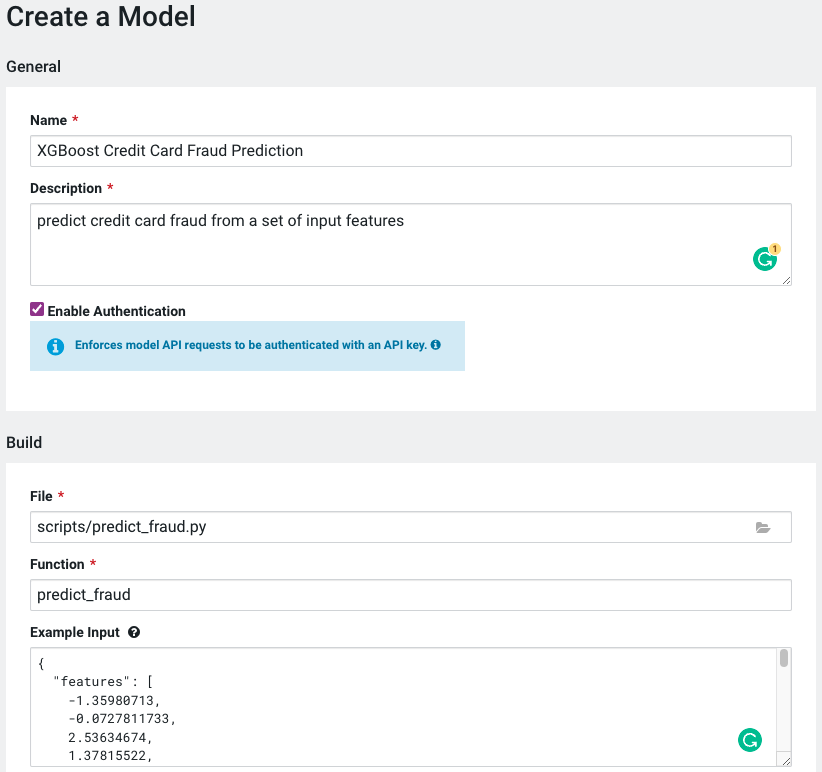

Now just hit Deploy Model and you're all set!

***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***